# Modeling

The modeling phase aims to build and evaluate models that support the business objectives, using the analysis ready dataset produced in the `Data Preparation` phase

In [35]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.10.1


In [36]:
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

input_dir = "../data/processed/"
pkl_path = os.path.join(input_dir, "prepared_art500k_subset_paintings.pkl")

df = pd.read_pickle(pkl_path)

print(f"DataFrame loaded from {pkl_path}")
print(df.info())

DataFrame loaded from ../data/processed/prepared_art500k_subset_paintings.pkl
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 4000 non-null   int64 
 1   image_path         4000 non-null   object
 2   type_landscape     4000 non-null   bool  
 3   type_mythological  4000 non-null   bool  
 4   type_portrait      4000 non-null   bool  
 5   type_religious     4000 non-null   bool  
dtypes: bool(4), int64(1), object(1)
memory usage: 78.2+ KB
None


## Select modeling technique

### Modeling technique
With the limited dataset, transfer learning will be used first. The GPU can be used for tensorflow/keras. One of the models in [keras.io/api/applications](https://keras.io/api/applications/) will be chosen.

The XCeption model has been selected to make a first iteration due to strong accuracy on ImageNet. Besides this is it also suitable for the local GPU

### Modeling assumptions
**Input shape:**
- All input images must be resized to the target dimensions (299x299, 3 channels)
- Images must be preprocessed with `keras.applications.xception.preprocess_input` before input to the model (scaling to [-1, 1]).

**Labels:**
- The number of output classes matches the unique values of the `TYPE` variable (4)

**Dataset Size:**
- Transfer learning with a pre-trained backbone assumes a moderate or small labeled dataset

**Distribution:**
- Model does not require input features to be normally distributed, but assumes the label distribution is sufficiently balanced for meaningful evaluation.

**Augmentation:**
- To enhance generalization, basic image augmentation (random flip, rotation, etc.) can be applied during training if the model performs poorly [keras.io/guides_transfer_learning](https://keras.io/guides/transfer_learning/)

## Test design
in the data preperation step the label was taken out of the dataframe. Now it needs to be added back

In [37]:
onehot_cols = ['type_landscape', 'type_mythological', 'type_portrait', 'type_religious']

# Convert one-hot to class label
df['label'] = np.argmax(df[onehot_cols].values, axis=1)
index_to_type = {i: col.replace('type_', '') for i, col in enumerate(onehot_cols)}
df['label_name'] = df['label'].map(index_to_type)

In [38]:
df.sample(n=5, random_state=SEED)

,id,image_path,type_landscape,type_mythological,type_portrait,type_religious,label,label_name
555,35811,../data/toy_dataset/35811.jpg,False,False,True,False,2,portrait
3491,7625,../data/toy_dataset/7625.jpg,False,False,True,False,2,portrait
527,40728,../data/toy_dataset/40728.jpg,False,True,False,False,1,mythological
3925,12868,../data/toy_dataset/12868.jpg,False,False,True,False,2,portrait
2989,34510,../data/toy_dataset/34510.jpg,True,False,False,False,0,landscape


Using stratification so all train/validation/test splits have relative proportions of each label. a split of 

In [39]:
# 80/20
train_df, temp_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=SEED
)

# 50/50 of the 20%
validation_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=SEED
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(validation_df)}")
print(f"Test samples: {len(test_df)}")

Training samples: 3200
Validation samples: 400
Test samples: 400


## Build model

In [41]:
BATCH_SIZE = 32
IMG_SIZE = (299, 299)
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE
ONE_HOT_DIMENSIONS = 4
DROPOUT_RATE = 0.4

Function to parse images on teh fly

In [42]:
def parse_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = keras.applications.xception.preprocess_input(image)
    return image, label

Create TensorFlow Datasets from DataFrame slices

In [43]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df['image_path'].values, train_df['label'].values)
).map(parse_image, num_parallel_calls=AUTOTUNE) \
 .batch(BATCH_SIZE) \
 .prefetch(AUTOTUNE)

validation_ds = tf.data.Dataset.from_tensor_slices(
    (validation_df['image_path'].values, validation_df['label'].values)
).map(parse_image, num_parallel_calls=AUTOTUNE) \
 .batch(BATCH_SIZE) \
 .prefetch(AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices(
    (test_df['image_path'].values, test_df['label'].values)
).map(parse_image, num_parallel_calls=AUTOTUNE) \
 .batch(BATCH_SIZE) \
 .prefetch(AUTOTUNE)

Load the XCeption model

In [44]:
keras.backend.clear_session()

base_model = keras.applications.Xception(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)
base_model.trainable = False

Build model head

In [45]:
inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = keras.layers.Dense(ONE_HOT_DIMENSIONS, activation='softmax')(x)
model = keras.Model(inputs, outputs)

Compile model

In [46]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
_____________________________________________

Train the model

In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
100/100 [==============================] - 32s 298ms/step - loss: 0.8623 - accuracy: 0.6522 - val_loss: 0.6496 - val_accuracy: 0.7325
Epoch 2/10
100/100 [==============================] - 35s 354ms/step - loss: 0.6344 - accuracy: 0.7528 - val_loss: 0.6037 - val_accuracy: 0.7425
Epoch 3/10
100/100 [==============================] - 36s 360ms/step - loss: 0.5777 - accuracy: 0.7747 - val_loss: 0.5877 - val_accuracy: 0.7575
Epoch 4/10
100/100 [==============================] - 36s 359ms/step - loss: 0.5509 - accuracy: 0.7778 - val_loss: 0.5825 - val_accuracy: 0.7575
Epoch 5/10
100/100 [==============================] - 31s 312ms/step - loss: 0.5256 - accuracy: 0.7950 - val_loss: 0.5817 - val_accuracy: 0.7550
Epoch 6/10
100/100 [==============================] - 30s 296ms/step - loss: 0.5130 - accuracy: 0.7934 - val_loss: 0.5821 - val_accuracy: 0.7575
Epoch 7/10
100/100 [==============================] - 30s 296ms/step - loss: 0.4992 - accuracy: 0.8044 - val_loss: 0.5797 - val_ac

### Loss plot

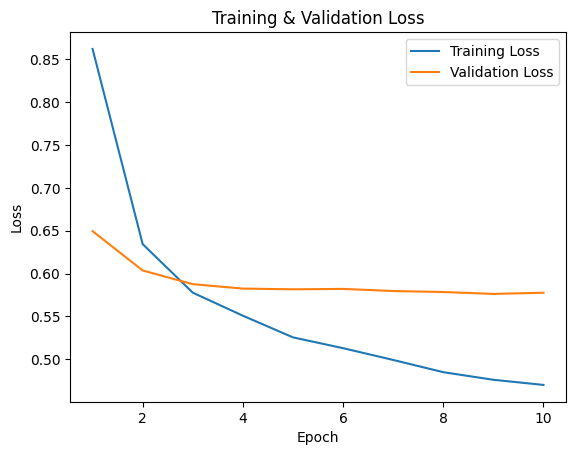

In [48]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Both curves fall steeply in the first 2–3 epochs. This means the learning rate and initial model capacity are sufficient to capture the broad structure quickly. After about epoch 3-4 validation loss flattens just below 0.6 whereas training loss keeps decreasing steadily down to below 0.5 by epoch 10.
This might indicate overfitting. The model continues to fit the training data better but those gains no longer generalize.
The gap between training and validation loss is modest at epoch 3 but grows bigger by epoch 10. A widening gap is also a sign of overfitting.

### Accuracy plot

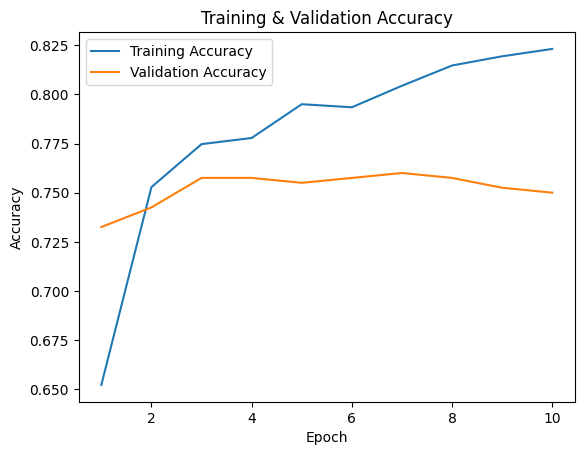

In [49]:
plt.figure()
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Validation accuracy climbs quickly showing the model learns the bulk of generalizable patterns very early. After epoch 3 validation accuracy stagnates and then dips slightly by epoch 10. Meanwhile, training accuracy continues rising reaching ~0.82 at epoch 10.

The gap between training and validation accuracy grows from almost nothing at epoch 2 to ~0.07 by epoch 10. This is a sign of overfitting.

In [50]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

13/13 [==============================] - 3s 253ms/step - loss: 0.5420 - accuracy: 0.7875
Test accuracy: 0.788


The accuracy is still quite good for the size of the dataset

It is intersting to see what the model does whith less epochs

## Model B

In [57]:
EPOCHS = 4

inputs = keras.Input(shape=(*IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(DROPOUT_RATE)(x)
outputs = keras.layers.Dense(ONE_HOT_DIMENSIONS, activation='softmax')(x)
modelB = keras.Model(inputs, outputs)

modelB.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

modelB.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 20,869,676
Trainable params: 8,196
Non-trainable params: 20,861,480
___________________________________________

In [58]:
historyB = modelB.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/4


100/100 [==============================] - 32s 294ms/step - loss: 0.8676 - accuracy: 0.6472 - val_loss: 0.6518 - val_accuracy: 0.7450
Epoch 2/4
100/100 [==============================] - 32s 324ms/step - loss: 0.6335 - accuracy: 0.7519 - val_loss: 0.6053 - val_accuracy: 0.7525
Epoch 3/4
100/100 [==============================] - 35s 349ms/step - loss: 0.5849 - accuracy: 0.7678 - val_loss: 0.5887 - val_accuracy: 0.7625
Epoch 4/4
100/100 [==============================] - 30s 299ms/step - loss: 0.5505 - accuracy: 0.7819 - val_loss: 0.5823 - val_accuracy: 0.7625


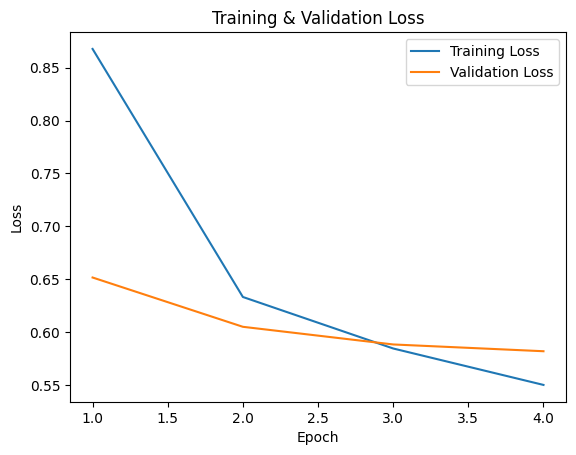

In [62]:
epochsB = range(1, len(historyB.history['loss']) + 1)

plt.figure()
plt.plot(epochsB, historyB.history['loss'], label='Training Loss')
plt.plot(epochsB, historyB.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Training loss and validation loss drop in the first three epochs. Most learnable signals are captured by epoch 3.
From epoch 3 to 4 training loss only inches down and validation loss barely budges.
There are very little additional generalizable performance.
At epoch 4 the gap is small indicating little overfitting

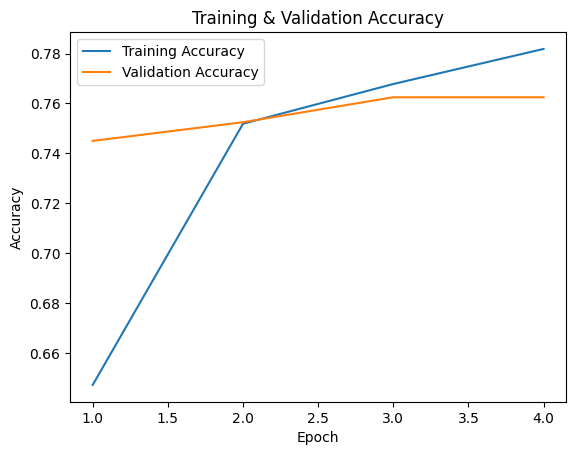

In [63]:
plt.figure()
plt.plot(epochsB, historyB.history['accuracy'], label='Training Accuracy')
plt.plot(epochsB, historyB.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

This accuracy plot tells the same story as the loss plot but with a few extra caveats

At epoch 1 to 2 the validation accuracy sits slightly above the training accuracy. By epoch 2 both curves meet around 0.75 showing that most signals are captured very quickly. From epoch 3 to 4 training accuracy climbs a bit.

That widening gap at epochs 4 signals the start of overfitting again

In [64]:
test_loss, test_acc = modelB.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

13/13 [==============================] - 3s 242ms/step - loss: 0.5624 - accuracy: 0.7900
Test accuracy: 0.790


# Asses Model

During this modelling phase 3 models are created.


**Previous iteration**
- base model: Xception
- Training samples: 640
- Validation samples: 80
- Test samples: 80
- DROPOUT_RATE = 0.4
- BATCH_SIZE = 32
- IMG_SIZE = (299, 299)
- AUTOTUNE = tf.data.AUTOTUNE
- ONE_HOT_DIMENSIONS = 4
- EPOCHS = 10

- accuracy on test set: 0.800
- model fit time: 1m 8.4s


General value for all models
- base model: Xception
- Training samples: 3200
- Validation samples: 400
- Test samples: 400
- BATCH_SIZE = 32
- DROPOUT_RATE = 0.4
- IMG_SIZE = (299, 299)
- AUTOTUNE = tf.data.AUTOTUNE
- ONE_HOT_DIMENSIONS = 4


**ModelA**
- EPOCHS = 10
- accuracy on test set: 0.788
- model fit time: 5m 19.4s

**ModelB**
- EPOCHS = 5
- accuracy on test set: 0.790
- model fit time: 2m 9.4s



## Conclusion
Across the previous iterations best model and the two new models, with the same xception backbone and enlarged dataset. is the old model still the best performant on the test set.

Although Model B slightly outperforms Model A while cutting training time by more than 50 % both plateau around ~0.79 test accuracy. This suggests most of the easy gains are exracted from a frozen backbone and head only training with this dataset.

In the next iteration fine tuning can be tried on the xception top layers, this might be the only impactfull change left with the currect data. Fine tuning might let the model adapt to unique brush strokes in the paintings or compositional styles

## Save for evaluation
Saving the model will not be performed as previous model has not been optimized